#Load and Unzip the Input Graphs

In [1]:
!unzip  /content/tsp_dataset.zip

Archive:  /content/tsp_dataset.zip
   creating: tsp_dataset/
  inflating: tsp_dataset/pcb442.tsp  
  inflating: tsp_dataset/berlin52.tsp  
  inflating: tsp_dataset/eil51.tsp   
  inflating: tsp_dataset/ulysses16.tsp  
  inflating: tsp_dataset/kroD100.tsp  
  inflating: tsp_dataset/gr202.tsp   
  inflating: tsp_dataset/ch150.tsp   
  inflating: tsp_dataset/gr229.tsp   
  inflating: tsp_dataset/d493.tsp    
  inflating: tsp_dataset/dsj1000.tsp  
  inflating: tsp_dataset/kroA100.tsp  
  inflating: tsp_dataset/ulysses22.tsp  
  inflating: tsp_dataset/burma14.tsp  


#Imports

In [2]:
import time
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

#Algorithms

In [3]:
class TSP_Solver:

  def __init__(self, verbose=False):

    self.verbose = verbose
    self.preorder_result = []
    self.total_weight_two_approx = 0
    self.pc = [] # partial circuit for RandomInsertion
    self.total_weight_random_ins = 0
    self.pc1 = [] # partial circuit for CheapestInsertion
    self.total_weight_cheapest_ins = 0

  def graphConstructor(self, edgeList):

    meta_data, self.graph = edgeList[0], edgeList[1:]
    self.name, self.V = meta_data['name'], len(self.graph)
    if self.verbose:print(f"Graph: {self.name}\n")

  def __SanityCheck(self, cycle):

    cycle_ = sorted(set(cycle))
    assert len(cycle_) == len(cycle) - 1, "What you found is not a hamiltonian cycle"
    assert cycle_ == list(range(0, self.V)), "What you found does not touch all nodes"

  def __PRIM(self, G, s):

    '''
      This function performs PRIM's algorithm, using HEAP to obtain the MST.
    '''

    inf, number_of_edges = float('inf'), 0
    V = len(G)
    visited = [0 for _ in range(V)]
    MST = list(map(lambda x: list(map(lambda y:0, x)), G))

    visited[s] = True
    while (number_of_edges < V - 1):
      minimum = inf
      x = 0
      y = 0
      for i in range(V):
          if visited[i]:
              for j in range(V):
                  if ((not visited[j]) and G[i][j]):  
                      if minimum > G[i][j]:
                          minimum = G[i][j]
                          x = i
                          y = j
      
      MST[x][y], MST[y][x] = G[x][y], G[x][y]
      visited[y] = True
      number_of_edges += 1

    return MST

  def __preorder(self, G, start):

    self.preorder_result.append(start) # print v

    if len(self.preorder_result) > 1: # Apart from visiting the tree, it also computes the sum of weights
      self.total_weight_two_approx += self.graph[self.preorder_result[-1]][self.preorder_result[-2]]

    for i in range(len(G)):
      if G[start][i] and i not in self.preorder_result:
        self.__preorder(G, i)

  def Two_approx_solver(self, s=0):

    self.__preorder(self.__PRIM(self.graph, s), s) # applying preorder visiting on obtained MST
    # H' = PREORDER(T*, r) where T*=PRIM(G, r') and r=r'
    self.total_weight_two_approx += self.graph[self.preorder_result[-1]][s] # adding starting point at the
    # end to create a cycle
    self.suboptimal_hamiltonian_cycle = self.preorder_result + [s] # adding starting point at the
    # end to create a cycle -> RETURN <H', vi1> where vir is starting point

    self.__SanityCheck(self.suboptimal_hamiltonian_cycle)

    if self.verbose:print(f"The result of 2-approx algorithm: {self.total_weight_two_approx}")

    return self.total_weight_two_approx

  def RandomInsertion(self):

    # Initialization
    self.pc.append(0) 
    nodes = [i for i in range(1, self.V)] # 0 has already been selected
    minimum = float('inf')

    for i in range(len(self.graph)):
      if self.graph[0][i]:
        if self.graph[0][i] < minimum:

          minimum = self.graph[0][i]
          j = i
    self.pc.append(j)
    nodes.remove(j)

    while len(self.pc) < self.V:
      # Selection
      k = random.choice(nodes)
      nodes.remove(k)
      # Insertion
      minimum =  float('inf')

      for idx in range(len(self.pc)-1):

        i, j = self.pc[idx], self.pc[idx+1] # edge {i, j}
        wik, wkj, wij = self.graph[i][k], self.graph[k][j], self.graph[i][j]
        w = wik + wkj - wij

        if w < minimum:
          minimum = w
          idx_of_k = idx+1 # the location where k must be inserted

      self.pc.insert(idx_of_k, k)

    for el in range(len(self.pc)-1): 
      self.total_weight_random_ins += self.graph[self.pc[el]][self.pc[el+1]]

    self.pc.append(self.pc[0]) #adding starting point at the end to create a cycle
    self.total_weight_random_ins += self.graph[self.pc[-2]][self.pc[-1]] #adding starting
    # point at the end to create a cycle
    self.__SanityCheck(self.pc)

    if self.verbose:print(f"The result of RandomInsertion algorithm: {self.total_weight_random_ins}")

    return self.total_weight_random_ins

  def CheapestInsertion(self):

    # Initialization
    self.pc1.append(0) 
    nodes = [i for i in range(1, self.V)] # 0 has already been selected
    minimum = float('inf')

    for i in range(len(self.graph)):
      if self.graph[0][i]:
        if self.graph[0][i] < minimum:

          minimum = self.graph[0][i]
          j = i
    self.pc1.append(j)
    nodes.remove(j)

    while len(self.pc1) < self.V:

      minimum = float('inf')

      for k in nodes:        
        for idx in range(len(self.pc1)-1):

          i, j = self.pc1[idx], self.pc1[idx+1] # edge {i, j}
          wik, wkj, wij = self.graph[i][k], self.graph[k][j], self.graph[i][j]
          w = wik + wkj - wij

          if w < minimum:
            minimum = w
            selected_k = k
            idx_of_k = idx+1 # the location where k must be inserted

      self.pc1.insert(idx_of_k, selected_k)
      nodes.remove(selected_k)

    for el in range(len(self.pc1)-1): 
      self.total_weight_cheapest_ins += self.graph[self.pc1[el]][self.pc1[el+1]]

    self.pc1.append(self.pc1[0]) #adding starting point at the end to create a cycle
    self.total_weight_cheapest_ins += self.graph[self.pc1[-2]][self.pc1[-1]] #adding starting
    # point at the end to create a cycle
    self.__SanityCheck(self.pc1)

    if self.verbose:print(f"The result of CheapestInsertion algorithm: {self.total_weight_cheapest_ins}")

    return self.total_weight_cheapest_ins

#Prepare the Data + Run Algorithms + Analysis

##Loading the data and construct the graphs

In [5]:
root_path = "/content/tsp_dataset/"
inputs = []
file_names = {'burma14.tsp':3323,'ulysses16.tsp':6859,'ulysses22.tsp':7013,'eil51.tsp':426,
 'berlin52.tsp':7542,'kroD100.tsp':21294,'kroA100.tsp':21282,'ch150.tsp':6528,
 'gr202.tsp':40160,'gr229.tsp':134602,'pcb442.tsp':50778,'d493.tsp':35002,'dsj1000.tsp':18659688}

nodes_list = [14,16,22,51,52,100,100,150,202,229,442,493,1000]

for file_name in file_names:
   
  input = []
  with open(root_path + file_name) as f:

    meta_data = {}
    flag = False

    for i, line in enumerate(f.readlines()):

      if "EOF" in line: break
      elif "NAME" in line: meta_data.setdefault('name',line.split()[-1])
      elif "DIMENSION" in line: meta_data.setdefault('number_of_nodes',int(line.split()[-1]))
      elif "EDGE_WEIGHT_TYPE" in line: meta_data.setdefault('distance_type',line.split()[-1])
      elif "NODE_COORD_SECTION" in line: flag = True
      elif flag: input.append(list(map(lambda x: float(x), line.split()[-2:])))
      else: pass

    f.close()
    
  input.insert(0, meta_data)
  inputs.append(input)

In [6]:
def GEO(x, y):

  RRR = 6378.388

  x1, y1 = x
  x2, y2 = y

  deg_x1, deg_y1 = int(x1), int(y1)
  min_x1, min_y1 = x1 - deg_x1, y1 - deg_y1
  latitude1, longitude1 = np.pi*(deg_x1 + (5/3)*min_x1)/180, np.pi*(deg_y1 + (5/3)*min_y1)/180

  deg_x2, deg_y2 = int(x2), int(y2)
  min_x2, min_y2 = x2 - deg_x2, y2 - deg_y2
  latitude2, longitude2 = np.pi*(deg_x2 + (5/3)*min_x2)/180, np.pi*(deg_y2 + (5/3)*min_y2)/180

  q1 = np.cos(longitude1 - longitude2)
  q2 = np.cos(latitude1 - latitude2)
  q3 = np.cos(latitude1 + latitude2)

  dij = int(RRR*np.arccos(0.5*((1.0 + q1)*q2 - (1.0 - q1)*q3)) + 1.0)

  return dij

def EUC(x, y):

  x1, y1 = x
  x2, y2 = y

  dij = ((x1 - x2)**2 + (y1 - y2)**2)**0.5

  dij = int(dij) if dij-int(dij) < 0.5 else int(dij)+1

  return dij

def graphConstructor(inp):

  meta_data, cors = inp[0], inp[1:]
  distance_type = meta_data['distance_type']
  number_of_nodes = meta_data['number_of_nodes']

  adj_matrix = [[0 for _ in range(number_of_nodes)] for _ in range(number_of_nodes)]

  distance_calculator = GEO if distance_type == "GEO" else EUC

  for c in range(len(cors)):

    for r in range(c+1, len(cors)): # Distances are symmetric

      x, y = cors[c], cors[r]

      weight = distance_calculator(x, y)

      adj_matrix[c][r] = weight
      adj_matrix[r][c] = weight # Distances are symmetric

  adj_matrix.insert(0, meta_data)
  return adj_matrix

In [7]:
graphs = list(map(lambda x: graphConstructor(x), inputs))

In [8]:
graphs[0]

[{'distance_type': 'GEO', 'name': 'burma14', 'number_of_nodes': 14},
 [0, 153, 510, 706, 966, 581, 455, 70, 160, 372, 157, 567, 342, 398],
 [153, 0, 422, 664, 997, 598, 507, 197, 311, 479, 310, 581, 417, 376],
 [510, 422, 0, 289, 744, 390, 437, 491, 645, 880, 618, 374, 455, 211],
 [706, 664, 289, 0, 491, 265, 410, 664, 804, 1070, 768, 259, 499, 310],
 [966, 997, 744, 491, 0, 400, 514, 902, 990, 1261, 947, 418, 635, 636],
 [581, 598, 390, 265, 400, 0, 168, 522, 634, 910, 593, 19, 284, 239],
 [455, 507, 437, 410, 514, 168, 0, 389, 482, 757, 439, 163, 124, 232],
 [70, 197, 491, 664, 902, 522, 389, 0, 154, 406, 133, 508, 273, 355],
 [160, 311, 645, 804, 990, 634, 482, 154, 0, 276, 43, 623, 358, 498],
 [372, 479, 880, 1070, 1261, 910, 757, 406, 276, 0, 318, 898, 633, 761],
 [157, 310, 618, 768, 947, 593, 439, 133, 43, 318, 0, 582, 315, 464],
 [567, 581, 374, 259, 418, 19, 163, 508, 623, 898, 582, 0, 275, 221],
 [342, 417, 455, 499, 635, 284, 124, 273, 358, 633, 315, 275, 0, 247],
 [398, 376

##Test the algorithms and fill the table

In [9]:
for G in graphs:

  tsp_solver = TSP_Solver(verbose=True)
  tsp_solver.graphConstructor(G)
  _ = tsp_solver.RandomInsertion()
  _ = tsp_solver.CheapestInsertion()
  _ = tsp_solver.Two_approx_solver()
  print("-"*50)

Graph: burma14

The result of RandomInsertion algorithm: 3465
The result of CheapestInsertion algorithm: 3568
The result of 2-approx algorithm: 4003
--------------------------------------------------
Graph: ulysses16.tsp

The result of RandomInsertion algorithm: 7252
The result of CheapestInsertion algorithm: 7368
The result of 2-approx algorithm: 7788
--------------------------------------------------
Graph: ulysses22.tsp

The result of RandomInsertion algorithm: 7525
The result of CheapestInsertion algorithm: 7709
The result of 2-approx algorithm: 8308
--------------------------------------------------
Graph: eil51

The result of RandomInsertion algorithm: 460
The result of CheapestInsertion algorithm: 494
The result of 2-approx algorithm: 614
--------------------------------------------------
Graph: berlin52

The result of RandomInsertion algorithm: 8507
The result of CheapestInsertion algorithm: 9004
The result of 2-approx algorithm: 10402
------------------------------------------

In [13]:
columns = [['RandomInsertion','CheapestInsertion','2-Approx'], ['Solution','Time','Error']]
mux = pd.MultiIndex.from_product(columns)
df = pd.DataFrame(None, columns=mux)

numberOfExecutionPerSample = 10

avg_solution_RI, avg_solution_CI, avg_solution_TA = [], [], []
errors_RI, errors_CI, errors_TA = [], [], []
avg_exec_time_RI, avg_exec_time_CI, avg_exec_time_TA = [], [], []

for i,G in enumerate(graphs):

  solution_RI, solution_CI, solution_TA = [], [], []
  exec_time_RI, exec_time_CI, exec_time_TA = [], [], []

  for _ in range(numberOfExecutionPerSample):
    
    # RandomInsertion
    tsp_solver = TSP_Solver()
    tsp_solver.graphConstructor(G)

    start = time.time()
    solution = tsp_solver.RandomInsertion()
    end = time.time()
    solution_RI.append(solution)
    exec_time_RI.append(end-start)

    # CheapestInsertion
    tsp_solver = TSP_Solver()
    tsp_solver.graphConstructor(G)

    start = time.time()
    solution = tsp_solver.CheapestInsertion()
    end = time.time()
    solution_CI.append(solution)
    exec_time_CI.append(end-start)

    # 2-approx with different starting points
    tsp_solver = TSP_Solver()
    tsp_solver.graphConstructor(G)

    starting_point = random.choice(range(tsp_solver.V))
    start = time.time()
    solution = tsp_solver.Two_approx_solver(s=starting_point)
    end = time.time()
    solution_TA.append(solution)
    exec_time_TA.append(end-start)

  avg_sol_RI = sum(solution_RI)/numberOfExecutionPerSample
  avg_sol_CI = sum(solution_CI)/numberOfExecutionPerSample
  avg_sol_TA = sum(solution_TA)/numberOfExecutionPerSample
  avg_solution_RI.append(avg_sol_RI)
  avg_solution_CI.append(avg_sol_CI)
  avg_solution_TA.append(avg_sol_TA)

  avg_time_RI = sum(exec_time_RI)/numberOfExecutionPerSample
  avg_time_CI = sum(exec_time_CI)/numberOfExecutionPerSample
  avg_time_TA = sum(exec_time_TA)/numberOfExecutionPerSample
  avg_exec_time_RI.append(avg_time_RI)
  avg_exec_time_CI.append(avg_time_CI)
  avg_exec_time_TA.append(avg_time_TA)

  name_with_suffix = tsp_solver.name if '.tsp' in tsp_solver.name else tsp_solver.name + '.tsp'
  # This line is because of name-inconsistency in dataset
  optimal_solution = file_names[name_with_suffix]
  error_RI = (avg_sol_RI - optimal_solution) / optimal_solution
  error_CI = (avg_sol_CI - optimal_solution) / optimal_solution 
  error_TA = (avg_sol_TA - optimal_solution) / optimal_solution
  errors_RI.append(error_RI) 
  errors_CI.append(error_CI)
  errors_TA.append(error_TA)

  # Add to dataset
  df.at[name_with_suffix, 'RandomInsertion'] = [avg_sol_RI, avg_time_RI, error_RI]
  df.at[name_with_suffix, 'CheapestInsertion'] = [avg_sol_CI, avg_time_CI, error_CI]
  df.at[name_with_suffix, '2-Approx'] = [avg_sol_TA, avg_time_TA, error_TA]

In [14]:
df

RandomInsertion                     CheapestInsertion  \
                     Solution      Time     Error          Solution   
burma14.tsp            3437.3  0.000077  0.034397            3568.0   
ulysses16.tsp          7152.4  0.000109  0.042776            7368.0   
ulysses22.tsp          7245.9  0.000164   0.03321            7709.0   
eil51.tsp               461.6  0.000707  0.083568             494.0   
berlin52.tsp           8434.2  0.000737  0.118298            9004.0   
kroD100.tsp           23126.5    0.0026  0.086057           25204.0   
kroA100.tsp           23208.7  0.002877  0.090532           24942.0   
ch150.tsp              7281.9  0.005821  0.115487            8051.0   
gr202.tsp             44562.0  0.016101  0.109612           46480.0   
gr229.tsp            147589.8  0.015854   0.09649          154038.0   
pcb442.tsp            58397.2  0.065217  0.150049           60834.0   
d493.tsp              38598.7  0.078549  0.102757           39969.0   
dsj1000.tsp        21008958.5  0.372786  0.125901        22291165.0   

                                       2-Approx                       
                     Time     Error    Solution       Time     Error  
burma14.tsp      0.000216  0.073729      4062.3   0.000219   0.22248  
ulysses16.tsp    0.000336  0.074209      7929.2   0.000344  0.156029  
ulysses22.tsp    0.000822  0.099244      8344.7   0.000673   0.18989  
eil51.tsp        0.009594  0.159624       605.4    0.00661  0.421127  
berlin52.tsp     0.010484  0.193848     10246.4   0.006976  0.358579  
kroD100.tsp      0.079961   0.18362     28866.6   0.046857  0.355621  
kroA100.tsp      0.076991  0.171976     29299.9   0.047881  0.376746  
ch150.tsp        0.259947  0.233303      9120.6    0.15313  0.397151  
gr202.tsp        0.675727  0.157371     51747.4   0.370409  0.288531  
gr229.tsp        0.972837  0.144396    179632.5   0.543779  0.334546  
pcb442.tsp       8.037369  0.198039     70686.6   4.309475  0.392071  
d493.tsp        11.013914  0.141906     45792.0   6.336664  0.308268  
dsj1000.tsp    102.550845  0.194616  25493529.8  55.552365  0.366236

##Visualization

###Time (algorithms)

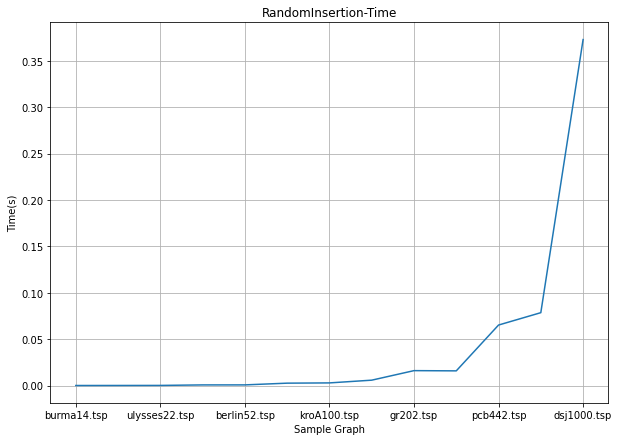

In [15]:
# RandomInsertion
plt.figure(figsize=(10,7))
df['RandomInsertion']['Time'].plot()
plt.title('RandomInsertion-Time')
plt.xlabel('Sample Graph')
plt.ylabel('Time(s)')
plt.grid()
plt.savefig('1.png')
plt.show()

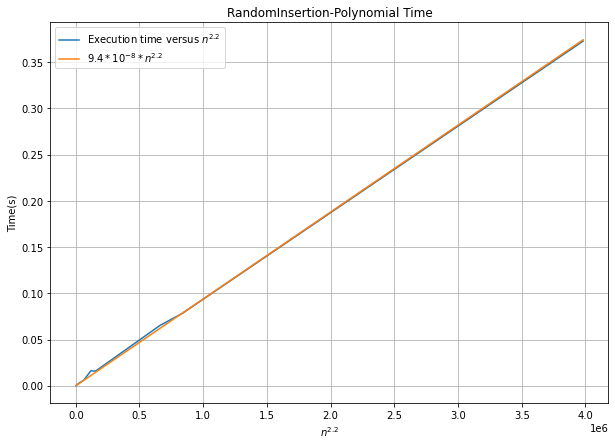

In [21]:
# RandomInsertion
plt.figure(figsize=(10,7))
x = list(map(lambda x: x**2.2, nodes_list))
y = df['RandomInsertion']['Time']
constant_f = 9.4e-8
plt.plot(x, y)
plt.plot(x, list(map(lambda z: z*constant_f, x)))
plt.title('RandomInsertion-Polynomial Time')
plt.xlabel('$n^{2.2}$')
plt.ylabel('Time(s)')
plt.grid()
plt.legend(['Execution time versus $n^{2.2}$', '$9.4 * 10^{-8} * n^{2.2}$'])
plt.savefig('1-a.png')
plt.show()

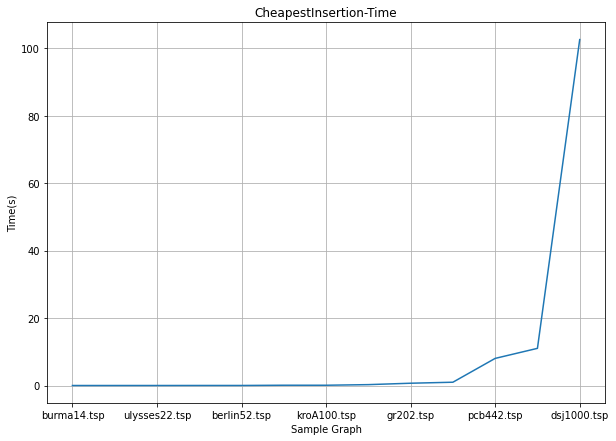

In [22]:
# CheapestInsertion
plt.figure(figsize=(10,7))
df['CheapestInsertion']['Time'].plot()
plt.title('CheapestInsertion-Time')
plt.xlabel('Sample Graph')
plt.ylabel('Time(s)')
plt.grid()
plt.savefig('2.png')
plt.show()

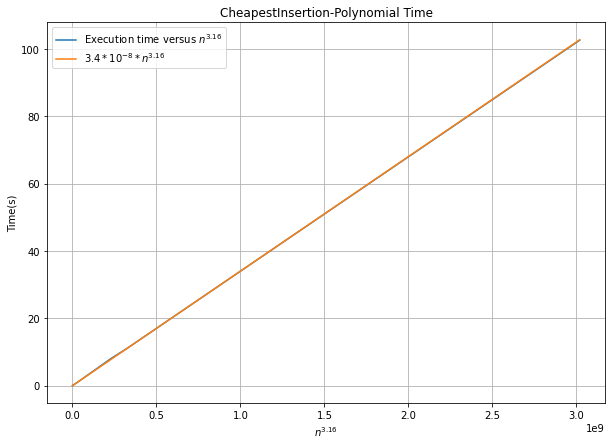

In [26]:
# CheapestInsertion
plt.figure(figsize=(10,7))
x = list(map(lambda x: x**3.16, nodes_list))
y = df['CheapestInsertion']['Time']
constant_f = 3.4e-8
plt.plot(x, y)
plt.plot(x, list(map(lambda z: z*constant_f, x)))
plt.title('CheapestInsertion-Polynomial Time')
plt.xlabel('$n^{3.16}$')
plt.ylabel('Time(s)')
plt.grid()
plt.legend(['Execution time versus $n^{3.16}$', '$3.4 * 10^{-8} * n^{3.16}$'])
plt.savefig('2-a.png')
plt.show()

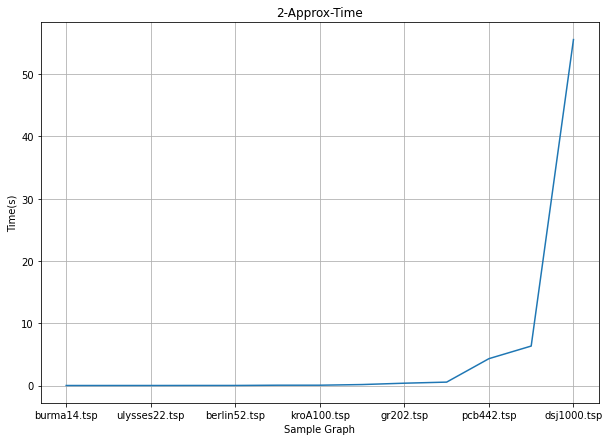

In [27]:
# 2-Approx
plt.figure(figsize=(10,7))
df['2-Approx']['Time'].plot()
plt.title('2-Approx-Time')
plt.xlabel('Sample Graph')
plt.ylabel('Time(s)')
plt.grid()
plt.savefig('3.png')
plt.show()

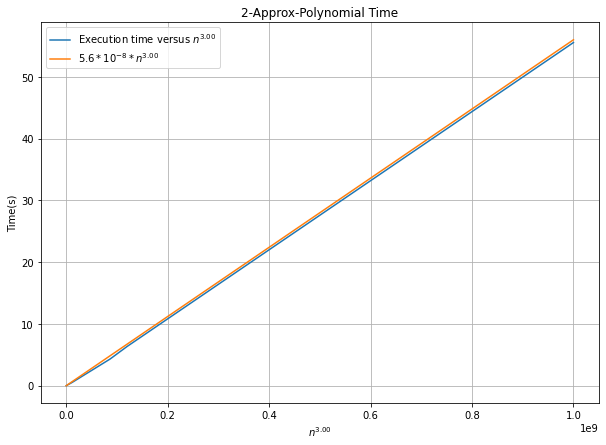

In [33]:
# 2-Approx
plt.figure(figsize=(10,7))
x = list(map(lambda x: x**3.00, nodes_list))
y = df['2-Approx']['Time']
constant_f = 5.6e-8
plt.plot(x, y)
plt.plot(x, list(map(lambda z: z*constant_f, x)))
plt.title('2-Approx-Polynomial Time')
plt.xlabel('$n^{3.00}$')
plt.ylabel('Time(s)')
plt.grid()
plt.legend(['Execution time versus $n^{3.00}$', '$5.6 * 10^{-8} * n^{3.00}$'])
plt.savefig('3-a.png')
plt.show()

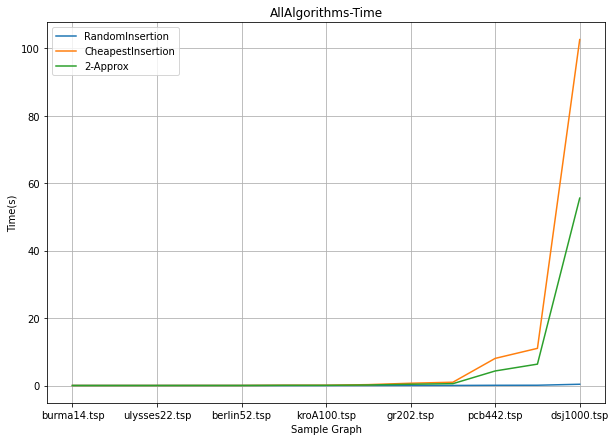

In [34]:
# All algorithms
plt.figure(figsize=(10,7))
df['RandomInsertion']['Time'].plot()
df['CheapestInsertion']['Time'].plot()
df['2-Approx']['Time'].plot()
plt.title('AllAlgorithms-Time')
plt.xlabel('Sample Graph')
plt.ylabel('Time(s)')
plt.legend(['RandomInsertion','CheapestInsertion','2-Approx'])
plt.grid()
plt.savefig('4.png')
plt.show()

###Error (algorithms)

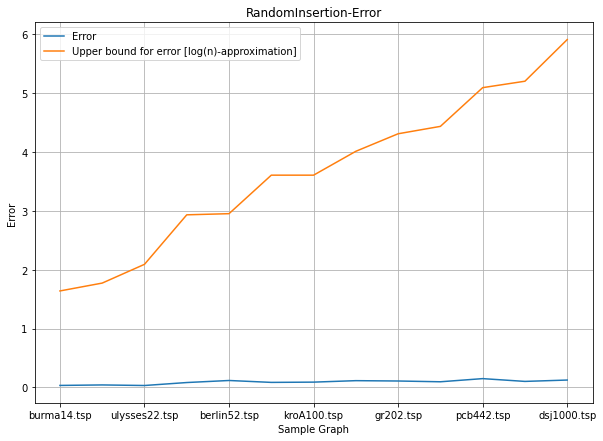

In [35]:
# RandomInsertion -> log(n)-approximation
plt.figure(figsize=(10,7))
df['RandomInsertion']['Error'].plot()
plt.plot([np.log(i)-1 for i in nodes_list])
plt.title('RandomInsertion-Error')
plt.xlabel('Sample Graph')
plt.ylabel('Error')
plt.grid()
plt.legend(['Error', 'Upper bound for error [log(n)-approximation]'])
plt.savefig('5.png')
plt.show()

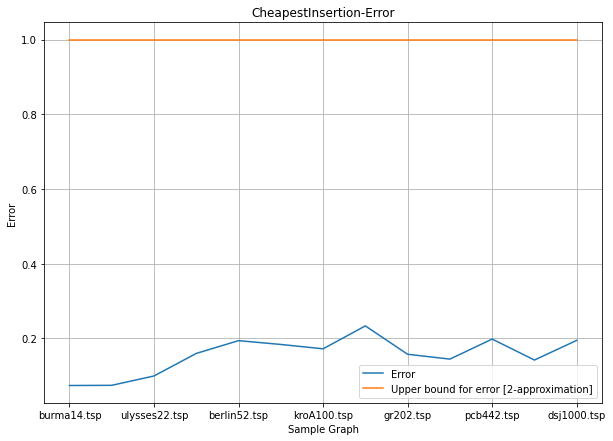

In [36]:
# CheapestInsertion -> 2-approximation
plt.figure(figsize=(10,7))
df['CheapestInsertion']['Error'].plot()
plt.plot([2-1 for i in nodes_list])
plt.title('CheapestInsertion-Error')
plt.xlabel('Sample Graph')
plt.ylabel('Error')
plt.grid()
plt.legend(['Error', 'Upper bound for error [2-approximation]'])
plt.savefig('6.png')
plt.show()

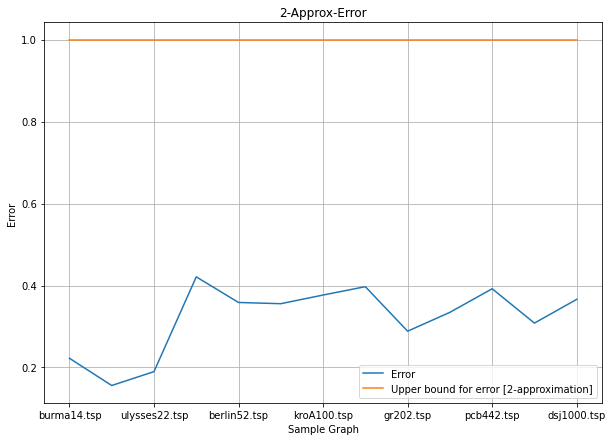

In [37]:
# 2-Approx -> 2-approximation
plt.figure(figsize=(10,7))
df['2-Approx']['Error'].plot()
plt.plot([2-1 for i in nodes_list])
plt.title('2-Approx-Error')
plt.xlabel('Sample Graph')
plt.ylabel('Error')
plt.grid()
plt.legend(['Error', 'Upper bound for error [2-approximation]'])
plt.savefig('7.png')
plt.show()

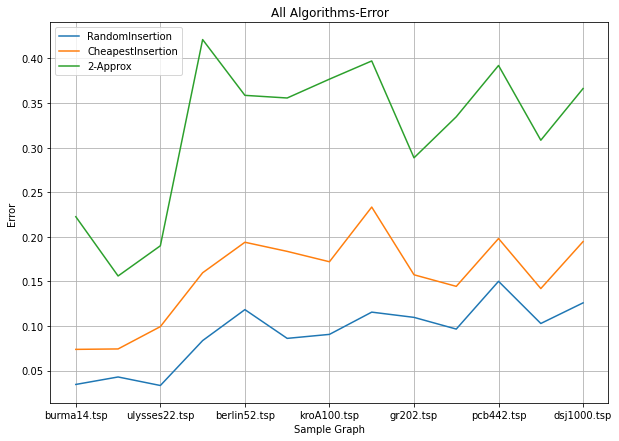

In [40]:
# All algorithms
plt.figure(figsize=(10,7))
df['RandomInsertion']['Error'].plot()
df['CheapestInsertion']['Error'].plot()
df['2-Approx']['Error'].plot()
plt.title('All Algorithms-Error')
plt.xlabel('Sample Graph')
plt.ylabel('Error')
plt.legend(['RandomInsertion','CheapestInsertion','2-Approx'])
plt.grid()
plt.savefig('8.png')
plt.show()

### Time (on a sample)

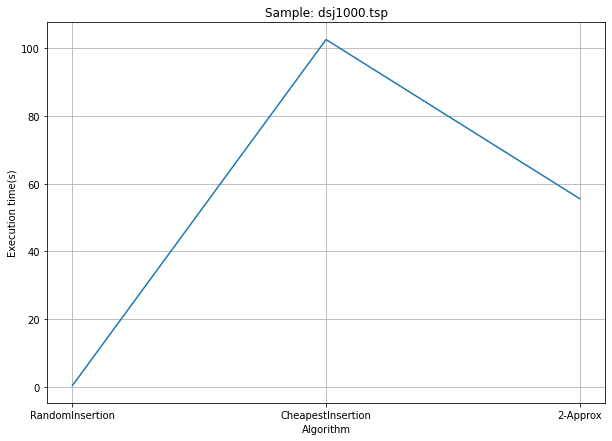

In [41]:
plt.figure(figsize=(10,7))
sample = 12

RIT = df['RandomInsertion']['Time'][sample]
CIT = df['CheapestInsertion']['Time'][sample]
TAT = df['2-Approx']['Time'][sample]

plt.title(f"Sample: {df.index[sample]}")
plt.plot(['RandomInsertion','CheapestInsertion','2-Approx'], [RIT, CIT, TAT])
plt.xlabel("Algorithm")
plt.ylabel("Execution time(s)")
plt.grid()
plt.savefig('9.png')
plt.show() # Time => RandomInsertion better than 2-Approx better than CheapestInsertion

### Error (on a sample)

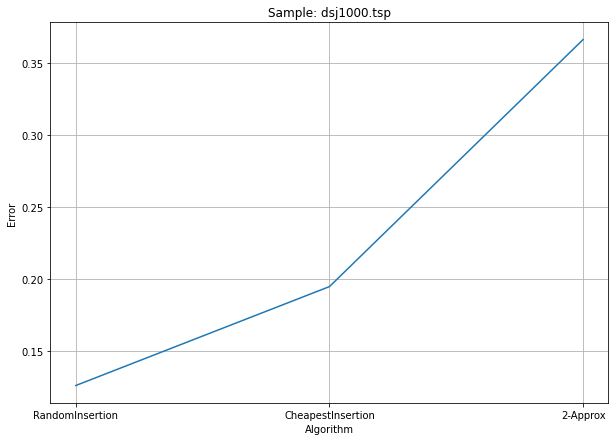

In [42]:
plt.figure(figsize=(10,7))

RIT = df['RandomInsertion']['Error'][sample]
CIT = df['CheapestInsertion']['Error'][sample]
TAT = df['2-Approx']['Error'][sample]

plt.title(f"Sample: {df.index[sample]}")
plt.plot(['RandomInsertion','CheapestInsertion','2-Approx'], [RIT, CIT, TAT])
plt.xlabel("Algorithm")
plt.ylabel("Error")
plt.grid()
plt.savefig('10.png')
plt.show() # Error => RandomInsertion better than CheapestInsertion better than 2-Approx

#Originalities

In [ ]:
# Functions to produce all hamiltonian cycles
def isSafe(v, graph, path, pos):

    if graph[path[pos - 1]][v] == 0:
        return False
    for i in range(pos):
        if path[i] == v:
            return False
    return True

hasCycle = False
def hamCycle(graph):

    result = []
    global hasCycle
    hasCycle = False
    path = []
    path.append(0)
    visited = [False]*(len(graph))
    for i in range(len(visited)):
        visited[i] = False
    visited[0] = True
    FindHamCycle(graph, 1, path, visited)

def FindHamCycle(graph, pos, path, visited):
   
    if pos == len(graph):
        if graph[path[-1]][path[0]] != 0:
            path.append(0)
            print(path, file=open("result.txt", "a"))
            path.pop()
            hasCycle = True
    for v in range(len(graph)):
        if isSafe(v, graph, path, pos) and not visited[v]:
            path.append(v)
            visited[v] = True
            FindHamCycle(graph, pos + 1, path, visited)
            visited[v] = False
            path.pop()

# Function to iterate all possible hamiltonian cycles and compute total weights corresponding to each cylce.
def Cycle_iterator(graph):

  weights = []
  with open("result.txt") as f:
    for loop in f.readlines():
      C = eval(loop)
      w = 0
      for node in range(len(C)-1):
        w += graph[C[node]][C[node+1]]
      weights.append([C, w])

    f.close()
  return weights

def TSP_Solver_Exact(cycles):

  c = {i:v for i, (k, v) in enumerate(cycles)}

  idx, w = sorted(c.items(), key=lambda x: x[1])[0]

  return cycles[idx]

##Test on randomly generated graph

In [ ]:
!rm -rf /content/result.txt

G = [{'name':'test1'},
     [0,10,15,25],
     [10,0,20,22],
     [15,20,0,26],
     [25,22,26,0]]
     
print(f"{G[0]['name']} => \n")

n = len(G)-1

hamCycle(G[1:])
cycles = Cycle_iterator(G[1:])
_, opt_sol = TSP_Solver_Exact(cycles=cycles)
print(f"Optimal Solution: {opt_sol}")
print(f"-"*30)

alg = TSP_Solver()
alg.graphConstructor(G)
RI_sol = alg.RandomInsertion()
CI_sol = alg.CheapestInsertion()
TA_sol = alg.Two_approx_solver()
print(f"RandomInsertion Solution: {RI_sol}")
print(f"-"*30)
print(f"CheapestInsertion Solution: {CI_sol}")
print(f"-"*30)
print(f"2-Approx Solution: {TA_sol}")
print(f"-"*30)
G[1:]

test1 => 

Optimal Solution: 73
------------------------------
RandomInsertion Solution: 73
------------------------------
CheapestInsertion Solution: 73
------------------------------
2-Approx Solution: 73
------------------------------
[[0, 10, 15, 25]
 [10, 0, 20, 22]
 [15, 20, 0, 26]
 [25, 22, 26, 0]]


In [ ]:
!rm -rf /content/result.txt

G = [{'name':'test2'},
     [0,1,2,2,1],
     [1,0,1,2,2],
     [2,1,0,1,2],
     [2,2,1,0,1],
     [1,2,2,1,0]]

print(f"{G[0]['name']} => \n")

n = len(G)-1

hamCycle(G[1:])
cycles = Cycle_iterator(G[1:])
_, opt_sol = TSP_Solver_Exact(cycles=cycles)
print(f"Optimal Solution: {opt_sol}")
print(f"-"*30)

alg = TSP_Solver()
alg.graphConstructor(G)
RI_sol = alg.RandomInsertion()
CI_sol = alg.CheapestInsertion()
TA_sol = alg.Two_approx_solver()
print(f"RandomInsertion Solution: {RI_sol}")
print(f"-"*30)
print(f"CheapestInsertion Solution: {CI_sol}")
print(f"-"*30)
print(f"2-Approx Solution: {TA_sol}")
print(f"-"*30)
G[1:]

test2 => 

Optimal Solution: 5
------------------------------
RandomInsertion Solution: 5
------------------------------
CheapestInsertion Solution: 5
------------------------------
2-Approx Solution: 5
------------------------------


[[0, 1, 2, 2, 1],
 [1, 0, 1, 2, 2],
 [2, 1, 0, 1, 2],
 [2, 2, 1, 0, 1],
 [1, 2, 2, 1, 0]]

In [ ]:
!rm -rf /content/result.txt

G = [{'name':'test3'},
     [0,3,10,13,12,7],
     [3,0,8,11,10,5],
     [10,8,0,9,9,4],
     [13,11,9,0,11,10],
     [12,10,9,11,0,6],
     [7,5,4,10,6,0]]

print(f"{G[0]['name']} => \n")

n = len(G)-1

hamCycle(G[1:])
cycles = Cycle_iterator(G[1:])
_, opt_sol = TSP_Solver_Exact(cycles=cycles)
print(f"Optimal Solution: {opt_sol}")
print(f"-"*30)

alg = TSP_Solver()
alg.graphConstructor(G)
RI_sol = alg.RandomInsertion()
CI_sol = alg.CheapestInsertion()
TA_sol = alg.Two_approx_solver()
print(f"RandomInsertion Solution: {RI_sol}")
print(f"-"*30)
print(f"CheapestInsertion Solution: {CI_sol}")
print(f"-"*30)
print(f"2-Approx Solution: {TA_sol}")
print(f"-"*30)
G[1:]

test3 => 

Optimal Solution: 44
------------------------------
RandomInsertion Solution: 44
------------------------------
CheapestInsertion Solution: 44
------------------------------
2-Approx Solution: 44
------------------------------


[[0, 3, 10, 13, 12, 7],
 [3, 0, 8, 11, 10, 5],
 [10, 8, 0, 9, 9, 4],
 [13, 11, 9, 0, 11, 10],
 [12, 10, 9, 11, 0, 6],
 [7, 5, 4, 10, 6, 0]]

In [ ]:
!rm -rf /content/result.txt

G = [{'name':'test4'},
     [0,1,3,1,4],
     [1,0,2,1,4],
     [3,2,0,3,2],
     [1,1,3,0,3],
     [4,4,2,3,0]]

print(f"{G[0]['name']} => \n")

n = len(G)-1

hamCycle(G[1:])
cycles = Cycle_iterator(G[1:])
_, opt_sol = TSP_Solver_Exact(cycles=cycles)
print(f"Optimal Solution: {opt_sol}")
print(f"-"*30)

alg = TSP_Solver()
alg.graphConstructor(G)
RI_sol = alg.RandomInsertion()
CI_sol = alg.CheapestInsertion()
TA_sol = alg.Two_approx_solver()
print(f"RandomInsertion Solution: {RI_sol}")
print(f"-"*30)
print(f"CheapestInsertion Solution: {CI_sol}")
print(f"-"*30)
print(f"2-Approx Solution: {TA_sol}")
print(f"-"*30)
G[1:]

test4 => 

Optimal Solution: 9
------------------------------
RandomInsertion Solution: 9
------------------------------
CheapestInsertion Solution: 9
------------------------------
2-Approx Solution: 9
------------------------------


[[0, 1, 3, 1, 4],
 [1, 0, 2, 1, 4],
 [3, 2, 0, 3, 2],
 [1, 1, 3, 0, 3],
 [4, 4, 2, 3, 0]]

In [ ]:
!rm -rf /content/result.txt

ws = [i for i in range(1,1000)]

G = [[random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)],
     [random.choice(ws) for _ in range(8)]]

for i in range(8):
  for j in range(8):
    if i==j: G[i][j]=0
    else:G[i][j] = G[j][i]

G.insert(0, {'name':'test5'})
    
print(f"{G[0]['name']} => \n")

n = len(G)-1

hamCycle(G[1:])
cycles = Cycle_iterator(G[1:])
ham_cycle, opt_sol = TSP_Solver_Exact(cycles=cycles)
print(f"Optimal Solution: {opt_sol}")
print(f"Optimal Cycle: {ham_cycle}")
print(f"-"*30)

alg = TSP_Solver()
alg.graphConstructor(G)
RI_sol = alg.RandomInsertion()
CI_sol = alg.CheapestInsertion()
TA_sol = alg.Two_approx_solver()
print(f"RandomInsertion Solution: {RI_sol}")
print(f"Sub-optimal Cycle: {alg.pc}")
print(f"Error: {(RI_sol - opt_sol)/opt_sol:.3f}   vs   log(n)-1: {np.log(n)-1:.3f}")

print(f"-"*30)
print(f"CheapestInsertion Solution: {CI_sol}")
print(f"Sub-optimal Cycle: {alg.pc1}")
print(f"Error: {(CI_sol - opt_sol)/opt_sol:.3f}   vs   2-1: {1.000}")

print(f"-"*30)
print(f"2-Approx Solution: {TA_sol}")
print(f"Sub-optimal Cycle: {alg.suboptimal_hamiltonian_cycle}")
print(f"Error: {(TA_sol - opt_sol)/opt_sol:.3f}   vs   2-1: {1.000}")

print(f"-"*30)
G[1:]

test5 => 

Optimal Solution: 1446
Optimal Cycle: [0, 4, 3, 1, 7, 5, 2, 6, 0]
------------------------------
RandomInsertion Solution: 2079
Sub-optimal Cycle: [0, 3, 1, 7, 5, 2, 6, 4, 0]
Error: 0.438   vs   log(n)-1: 1.079
------------------------------
CheapestInsertion Solution: 1944
Sub-optimal Cycle: [0, 2, 6, 7, 5, 1, 3, 4, 0]
Error: 0.344   vs   2-1: 1.0
------------------------------
2-Approx Solution: 3429
Sub-optimal Cycle: [0, 4, 3, 6, 2, 7, 1, 5, 0]
Error: 1.371   vs   2-1: 1.0
------------------------------


[[0, 410, 377, 168, 63, 972, 293, 800],
 [410, 0, 926, 564, 776, 694, 720, 87],
 [377, 926, 0, 879, 596, 236, 138, 833],
 [168, 564, 879, 0, 56, 783, 586, 659],
 [63, 776, 596, 56, 0, 692, 814, 965],
 [972, 694, 236, 783, 692, 0, 940, 9],
 [293, 720, 138, 586, 814, 940, 0, 43],
 [800, 87, 833, 659, 965, 9, 43, 0]]